In [11]:
import os
from functools import cache
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from scipy.stats import pearsonr, bootstrap, linregress

%matplotlib notebook

DUMMY = 200
CORRECT = 2
old_results_file = "/Users/ryan/Downloads/results_old_helpers.csv"
new_results_file = "/Users/ryan/Downloads/results_af_glosa.csv"#results_new_helpers.csv"

new_glosa = True
glosa_fail = "PE2R4, PE2R3, PD2R2, TA2R, MTR1A, MTR1B, SUCR1, CLTR1, CLTR2, PE2R2, AGRG3, GRM2".split(", ")

def correct(df, key):
    return df[key] < CORRECT

def where(df, desc):
    # nan values in combind_rmsd       => combind opt failed, so use glide top pose
    # DUMMY in glide_rmsd/combind_rmsd => initial glide docking failed, so combind had no chance
    if desc == "glide_ok":
        return df["glide_rmsd"] != DUMMY
    elif desc == "combind_ok":
        return np.logical_not(np.isnan(df["combind_rmsd"]))
    elif desc == "any_pose_correct":
        return correct(df, "min_pose_rmsd")
    elif desc == "glide_correct":
        return correct(df, "glide_rmsd")
    elif desc == "combind_correct":
        return correct(df, "combind_rmsd")
    else:
        raise ValueError(desc)

['PE2R4', 'PE2R3', 'PD2R2', 'TA2R', 'MTR1A', 'MTR1B', 'SUCR1', 'CLTR1', 'CLTR2', 'PE2R2', 'AGRG3', 'GRM2']


In [12]:
def plot_melted(df, value_name, title):
    df_ = pd.DataFrame(df)
    df = pd.melt(df_, id_vars="protein", var_name="count type", value_name=value_name)

    fig, ax1 = plt.subplots()
    # error bars are really long so excluding them for now
    sns.barplot(data=df, x="protein", y=value_name, hue="count type")#, ci=None)

    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_ylim(0, 1.1)

    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    
    ax1.set_title(title)

False False
{'7CFM_lig-to-AF_7CFM', '7CFN_lig-to-AF_7CFM'}


/var/folders/8f/br10514d7s5flpfcf8y7j40r0000gn/T/ipykernel_16150/3954745058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old["combind_rmsd"][~where(old, "combind_ok")] = old["glide_rmsd"]
/var/folders/8f/br10514d7s5flpfcf8y7j40r0000gn/T/ipykernel_16150/3954745058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["combind_rmsd"][~where(new, "combind_ok")] = new["glide_rmsd"]


<IPython.core.display.Javascript object>


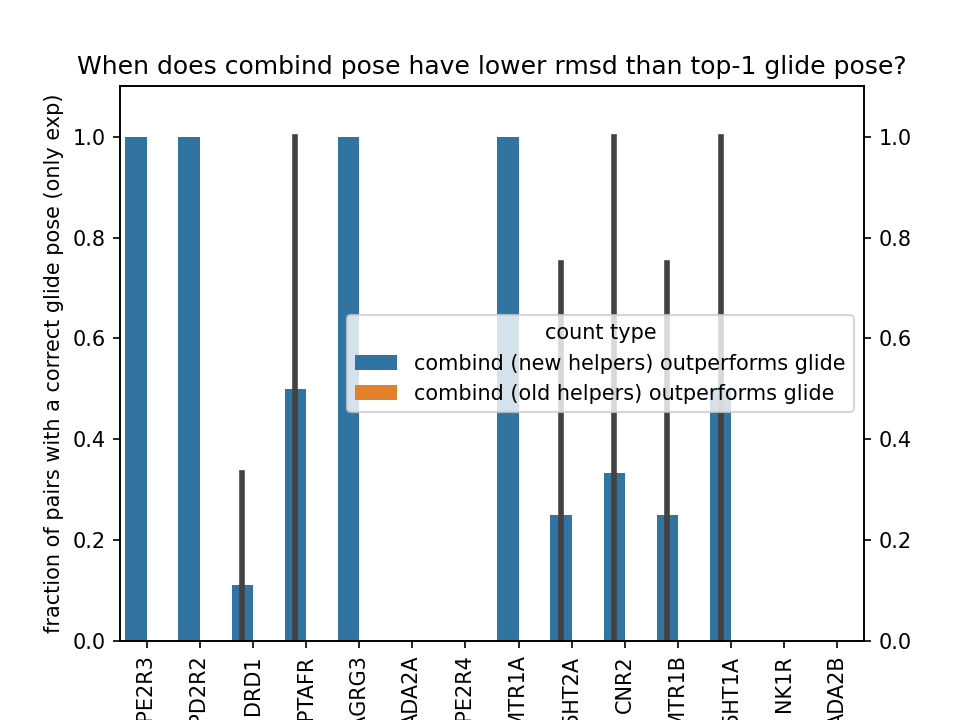

<IPython.core.display.Javascript object>


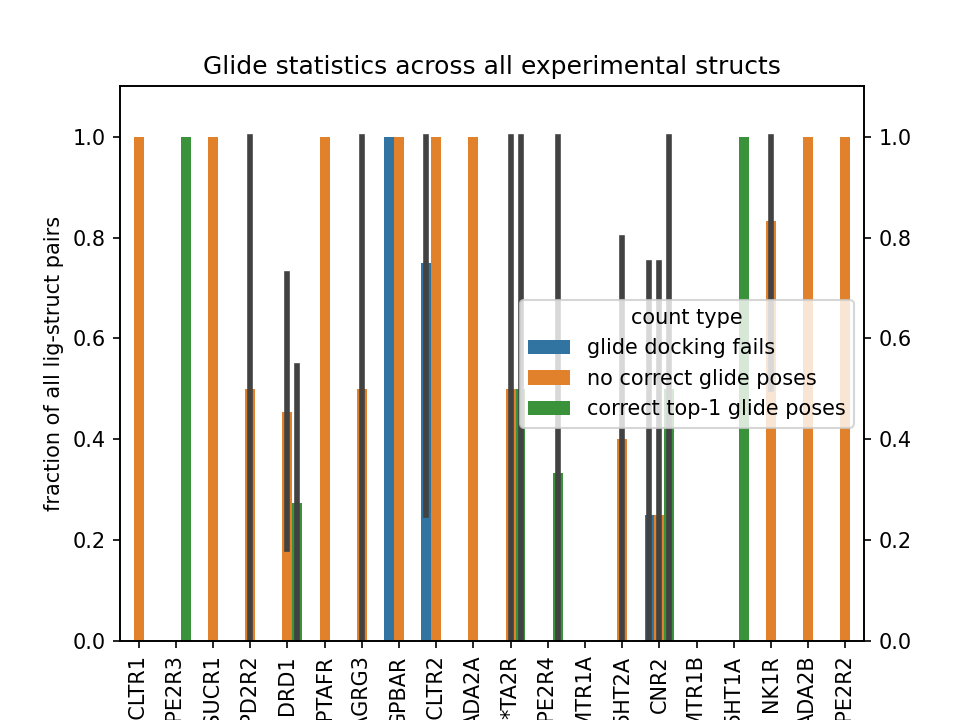

<IPython.core.display.Javascript object>


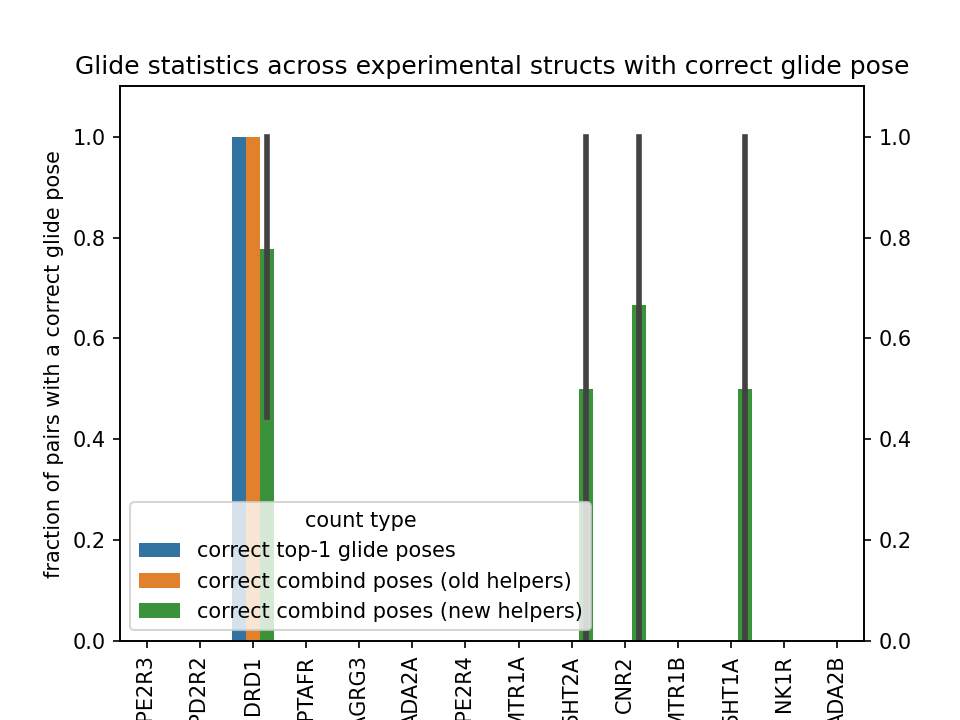

In [21]:
# Mask nans and dummy vals where appropriate
old = pd.read_csv(old_results_file)
new = pd.read_csv(new_results_file)

# Only select AF structures if comparing with glosa-minimized structures
if new_glosa:
    old = old[old["struct"].str.contains("AF_")]
    new["protein"] = [f"*{p}" if p in glosa_fail else p for p in new["protein"]]
    old["protein"] = [f"*{p}" if p in glosa_fail else p for p in old["protein"]]

old["combind_rmsd"][~where(old, "combind_ok")] = old["glide_rmsd"]
new["combind_rmsd"][~where(new, "combind_ok")] = new["glide_rmsd"]

print("AF_7CFM" in old["struct"], "AF_7CFM" in new["struct"])
print(set(old["pair"].values.tolist()) - set(new["pair"].values.tolist()))

#old = old[(old["type"] == "same_dock") | (old["type"] == "cross_dock")]
#new = new[(new["type"] == "same_dock") | (new["type"] == "cross_dock")]

fixed_stats = pd.DataFrame()
fixed_stats["protein"] = old["protein"]
fixed_stats["glide docking fails"] = (~where(old, "glide_ok")).astype(int)
fixed_stats["no correct glide poses"] = (~where(old, "any_pose_correct")).astype(int)
fixed_stats["correct top-1 glide poses"] = (where(old, "glide_correct")).astype(int)

# Filter out glide fails 
old = old[where(old, "glide_ok")]
new = new[where(new, "glide_ok")]

# Only consider cases where glide had a correct pose
old_ = old[where(old, "any_pose_correct")]
new_ = new[where(new, "any_pose_correct")]

cmp_stats = pd.DataFrame()
cmp_stats["protein"] = new_["protein"]
cmp_stats["correct top-1 glide poses"] = (where(old_, "glide_correct")).astype(int)
cmp_stats["correct combind poses (old helpers)"] = where(old_, "combind_correct").astype(int)
cmp_stats["correct combind poses (new helpers)"] = where(new_, "combind_correct").astype(int)

# How often is glide better than combind?
glide_better = pd.DataFrame()
glide_better["protein"] = new_["protein"]
glide_better["combind (new helpers) outperforms glide"] = (new_["combind_rmsd"] > new_["glide_rmsd"]).astype(int)
glide_better["combind (old helpers) outperforms glide"] = (old_["combind_rmsd"] > old_["glide_rmsd"]).astype(int)

plot_melted(glide_better, "fraction of pairs with a correct glide pose (only exp)", 
            "When does combind pose have lower rmsd than top-1 glide pose?")
plot_melted(fixed_stats, "fraction of all lig-struct pairs", "Glide statistics across all experimental structs")
plot_melted(cmp_stats, "fraction of pairs with a correct glide pose", 
            "Glide statistics across experimental structs with correct glide pose")

In [4]:
# Ignoring runs where glide failed, how does % correct change across docking tasks?
old["docking type"] = "combind (old helpers)"
old["rmsd"] = old["combind_rmsd"]

new["docking type"] = "combind (new helpers)"
new["rmsd"] = new["combind_rmsd"]

glide_cmp = old.copy()
glide_cmp["rmsd"] = glide_cmp["glide_rmsd"]
glide_cmp["docking type"] = "glide"

rmsds = pd.concat([old, new, glide_cmp], ignore_index=True)
# rmsds = rmsds[~np.isnan(rmsds["rmsd"])]        # If we're ignoring that failed combind => top glide pose
rmsds["fraction correct (<2Å)"] = correct(rmsds, "rmsd")

cross_dock = rmsds["type"] == "cross_dock"
rmsds["type"][cross_dock] = np.where(rmsds["mcss"] <= 0.5, "hard_cross_dock", "easy_cross_dock")

orders = ["same_dock", "easy_cross_dock", "hard_cross_dock", "AF_dock", "gpcrdb_dock", "prime_dock"]
ids = [orders.index(typ) for typ in rmsds["type"]]

#for docktype in rmsds["docking type"].value_counts().keys():
#    print(rmsds[rmsds["type"] == "cross_dock_distinct"][rmsds["docking type"] == docktype]["fraction correct (<2Å)"].mean(), docktype)

fig, axes = plt.subplots(2)
fig.tight_layout()
sns.barplot(data=rmsds, x="type", y="fraction correct (<2Å)", hue="docking type", ax=axes[0])
axes[0].set_title("Docking performance on all non-failed glide runs")
axes[0].set_xlabel("")

rmsds = rmsds[where(rmsds, "any_pose_correct")]  # If we ignore cases for which combind never had a chance at success
sns.barplot(data=rmsds, x="type", y="fraction correct (<2Å)", hue="docking type", ax=axes[1])
axes[1].set_title("Docking performance on runs where correct pose in T100")

/var/folders/8f/br10514d7s5flpfcf8y7j40r0000gn/T/ipykernel_16150/381032440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsds["type"][cross_dock] = np.where(rmsds["mcss"] <= 0.5, "hard_cross_dock", "easy_cross_dock")


ValueError: nan is not in list

In [5]:
def graph_sorted(axes, new, old, to_sort, i, j=None, legend=True, title=None, glide=False):
    using_new = to_sort == "new"
    
    new_rmsd = new["combind_rmsd"].values
    old_rmsd = old["combind_rmsd"].values if not glide else old["glide_rmsd"].values
    to_sort_arr = new_rmsd if using_new else old_rmsd
    
    ind = np.argsort(to_sort_arr)
    new_rmsd = new_rmsd[ind]
    old_rmsd = old_rmsd[ind]
    
    x = list(range(len(new_rmsd)))
    ax = axes[i] if j is None else axes[i][j]
    
    ax.tick_params(
        axis="x",          # changes apply to the x-axis
        which="both",      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    new_style = "b-" if using_new else "bo"
    old_style = "r-" if not using_new else "ro"
    
    old_label = "glide" if glide else "combind + old helpers"
    new_label = "combind + new helpers"
    ax.plot(x, new_rmsd, new_style, label=new_label, zorder=int(using_new) * 10, markersize=2)
    ax.plot(x, old_rmsd, old_style, label=old_label, zorder=int(not using_new) * 10, markersize=2)
    
    ax.fill_between(x, new_rmsd if using_new else old_rmsd, alpha=0.2)
    ax.axhline(y=2, linestyle="dotted", color="black")  # threshold for "correct"
    
#    to_score = new_rmsd if not using_new else old_rmsd
#    mask = (1 - np.ma.masked_invalid(to_score).mask).astype(bool)
#    ax.annotate("pearsonr = {:.3f}".format(pearsonr(np.array(x)[mask], new_rmsd[mask])[0]), (1, 1))
    
    if legend:
        ax.legend()
        ax.set_xlabel(f"Ligands sorted by increasing RMSD ({new_label if using_new else old_label})")
        ax.set_ylabel("RMSD")
    
    if title:
        ax.set_title(title)

<IPython.core.display.Javascript object>


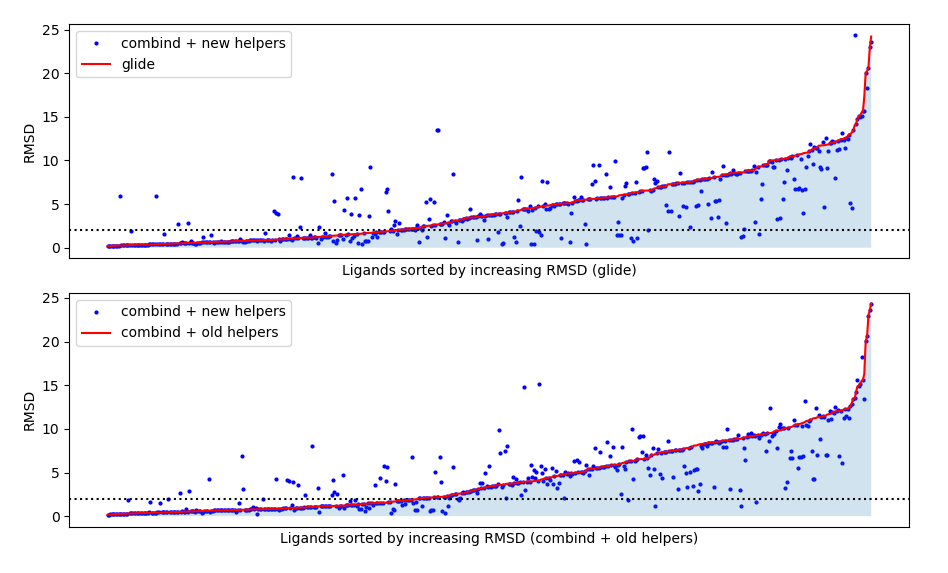

In [6]:
# Sort by old and new rmsds
fig, axes = plt.subplots(2, sharex=True, sharey=True)
fig.tight_layout()

graph_sorted(axes, new, old, "old", 0, glide=True)
graph_sorted(axes, new, old, "old", 1)

In [7]:
def perf(rmsd1, rmsd2):
#    return np.mean(np.ma.masked_invalid(rmsd1 - rmsd2))
    return np.mean(rmsd1 < 2) - np.mean(rmsd2 < 2)

<IPython.core.display.Javascript object>


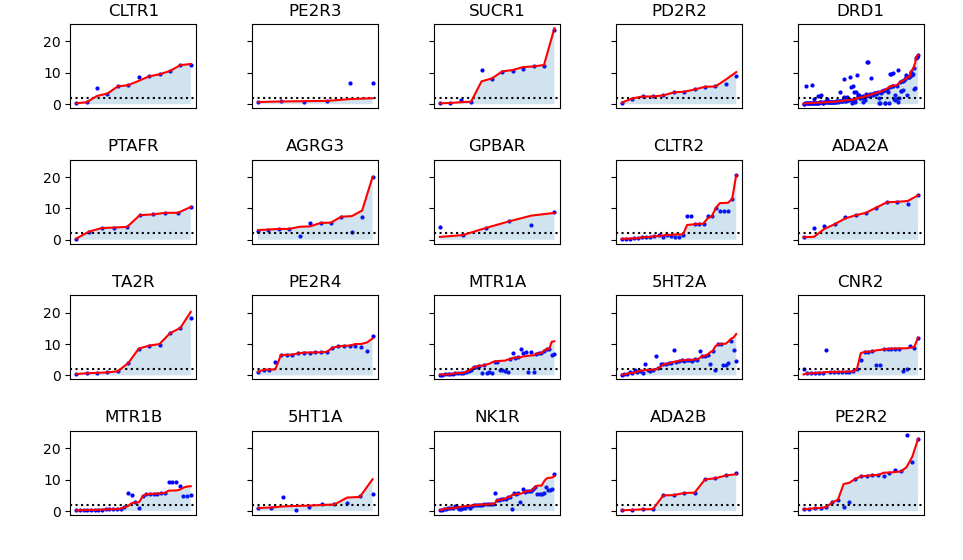

In [8]:
# Protein-by-protein analysis of combind performance differences
prots = new["protein"].unique()
fig, axes = plt.subplots(4, 5, sharey=True)
fig.tight_layout()

for i, prot in enumerate(prots):
    sele_new = new[new["protein"] == prot]
    sele_old = old[old["protein"] == prot]
    graph_sorted(axes, sele_new, sele_old, "old", i=i//5, j=i%5, legend=False, title=prot, glide=True)
    
    # missing = np.isnan(sele_new["combind_rmsd"])
    # ids = sele_new[missing][["lig", "struct"]]
    
    # print(f"{prot} ... {missing.sum()} / {len(sele_new)} missing")
    # print(f"   new combind vs old combind: {perf(sele_new['combind_rmsd'], sele_old['combind_rmsd'])}")
    # print(f"   new combind vs glide: {perf(sele_new['combind_rmsd'], sele_old['glide_rmsd'])}")
    # print(f"   old combind vs glide: {perf(sele_old['combind_rmsd'], sele_old['glide_rmsd'])}")
    #for miss, (lig, struct) in zip(missing, ids.values.tolist()):
    #    print(f"    {lig} - {struct} :")# {'' if miss else 'NOT'} MISSING")

<IPython.core.display.Javascript object>


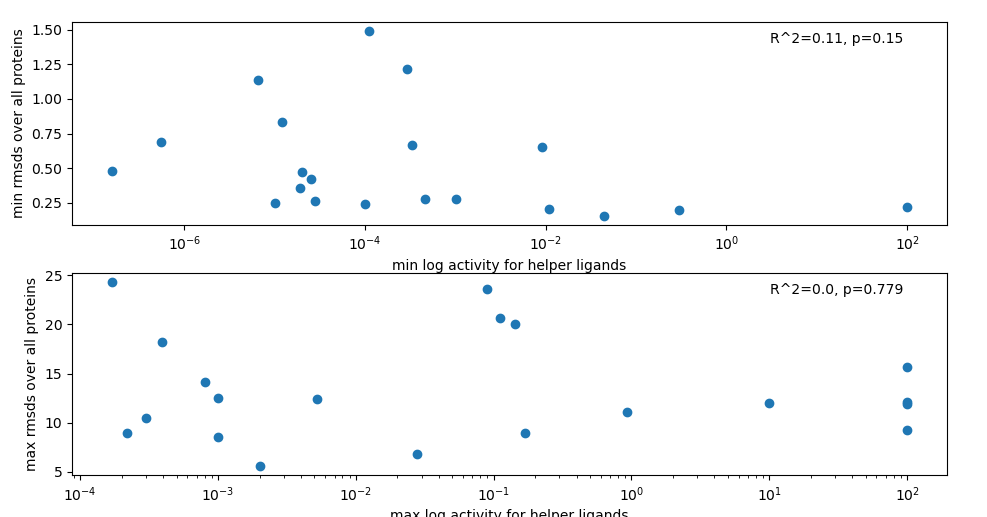

In [9]:
# How does helper ligand affinity affect performance?
helper_activities = pd.read_csv("/Users/ryan/sherlock_home/combind_multistruct_benchmarking/benchmark/activities.csv")
for class_c in ['GABR2','CASR', 'GRM2']:
    helper_activities = helper_activities[helper_activities["name"] != class_c]
helper_activities = helper_activities.fillna(100)  # No helper ligands -> 100 um affinity

min_acts = helper_activities["0"]  # '0' -> min, '19' -> max
max_acts = helper_activities["19"]  # '0' -> min, '19' -> max

min_rmds = [new[new["protein"] == prot]["combind_rmsd"].min() for prot in new["protein"].value_counts().keys()]
max_rmsd = [new[new["protein"] == prot]["combind_rmsd"].max() for prot in new["protein"].value_counts().keys()]

fig, axes = plt.subplots(2)
fig.tight_layout()

def plot_acts(ax, x, y, minmax1, minmax2):
    ax.scatter(x, y)
    ax.set_xscale("log")
    ax.set_xlabel(f"{minmax1} log activity for helper ligands")
    ax.set_ylabel(f"{minmax2} rmsds over all proteins")
    
    reg = linregress(np.log10(x), y)
    s = f"R^2={round(reg.rvalue ** 2, 2)}, p={round(reg.pvalue, 3)}"
    ax.text(0.95, 0.95, s, transform=ax.transAxes, ha="right", va="top")

plot_acts(axes[0], min_acts, min_rmds, "min", "min")
#plot_acts(axes[0][1], max_acts, min_rmds, "max", "min")
#plot_acts(axes[1][0], min_acts, max_rmsd, "min", "max")
plot_acts(axes[1], max_acts, max_rmsd, "max", "max")